In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Masking

Using TensorFlow backend.
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\silva\AppData\Roa

In [2]:
days = 10

In [3]:
def scale(training_set):
    # Feature Scaling
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    # Creating a data structure with 'days' time-steps and 1 output
    X_train = []
    y_train = []
    for i in range(days, training_set.shape[0]):
        X_train.append(training_set_scaled[i-days:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train, sc

In [4]:
def train_LSTM(X_train, y_train):
    model = Sequential()
    model.add(Masking(mask_value=-1, input_shape = (X_train.shape[1], 1)))
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 50, batch_size = 32)
    return model

In [5]:
def predict(dataset_train, dataset_test, model, sc):
    dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
    inputs = dataset_total[len(dataset_total) - dataset_test.shape[0] - days:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(days, inputs.shape[0]):
        X_test.append(inputs[i-days:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print(X_test.shape)
    # (273, 'days', 1)
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    return X_test, predicted_stock_price

In [6]:
def plot_results(dataset_test, predicted_stock_price):
    # Visualising the results
    plt.plot(dataset_test.values, color = 'red', label = 'Real')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted')
    plt.xticks(np.arange(0,dataset_test.shape[0],50))
    plt.xlabel('Time')
    plt.ylabel('Index')
    plt.legend()
    plt.show()

In [7]:
def impute_with_prediction(df_orig, df_imputed):
    for i in df_orig.index:
        if pd.isna(df_orig.loc[i]):
            df_orig.at[i] = df_imputed.loc[i]
    return df_orig

In [8]:
INPUT = 'output/\CompleteWeeklyIndexes'
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)

Epoch 1/50
772/772 [==============================] - 7s 9ms/step - loss: 0.0704
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0122
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0047
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0043
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0038
Epoch 13/50
772/772 [====

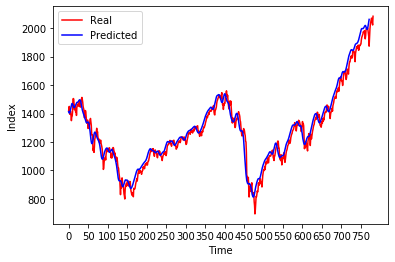

(273, 10, 1)


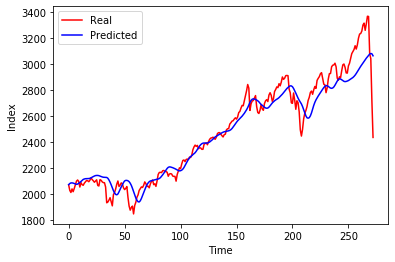

Epoch 1/50
772/772 [==============================] - 6s 8ms/step - loss: 0.0321
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0079
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0062
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 13/50
772/772 [====

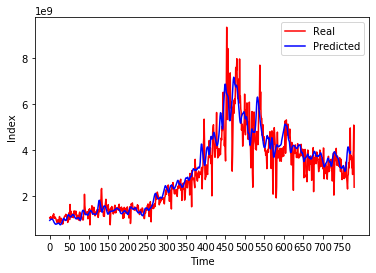

(273, 10, 1)


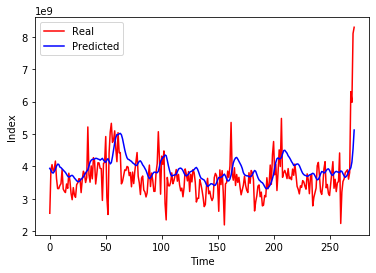

Epoch 1/50
772/772 [==============================] - 7s 9ms/step - loss: 0.0207
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0097
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0085
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0054
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 13/50
772/772 [====

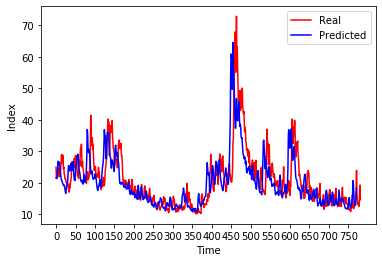

(273, 10, 1)


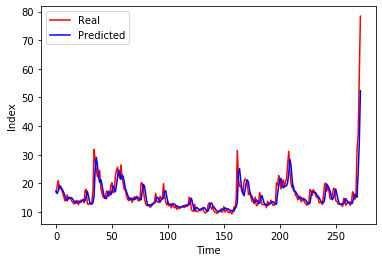

Epoch 1/50
772/772 [==============================] - 9s 11ms/step - loss: 0.0000e+00
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 12/50
772/772 [==============================] - 1s 1ms/

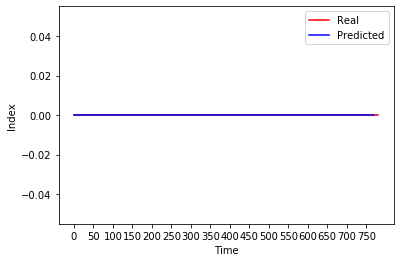

(273, 10, 1)


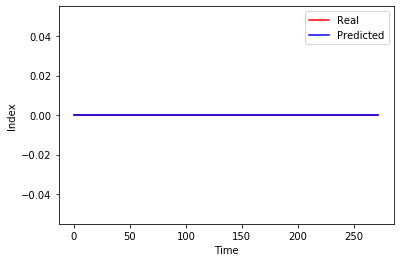

Epoch 1/50
772/772 [==============================] - 8s 11ms/step - loss: 0.0729
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0146
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0049
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0048
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0040
Epoch 13/50
772/772 [===

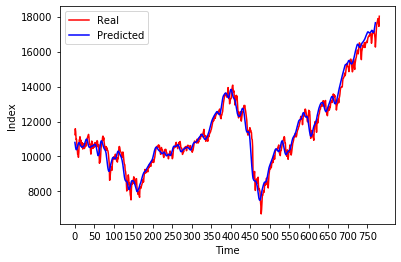

(273, 10, 1)


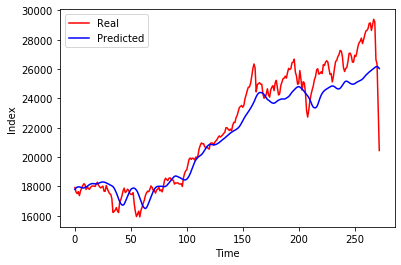

Epoch 1/50
772/772 [==============================] - 12s 16ms/step - loss: 0.0420
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0160
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 4/50
772/772 [==============================] - ETA: 0s - loss: 0.013 - 1s 1ms/step - loss: 0.0133
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0121
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0117

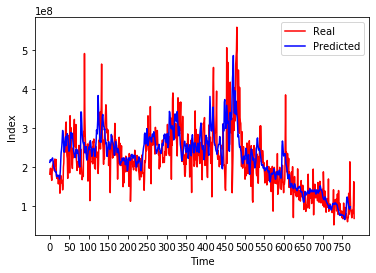

(273, 10, 1)


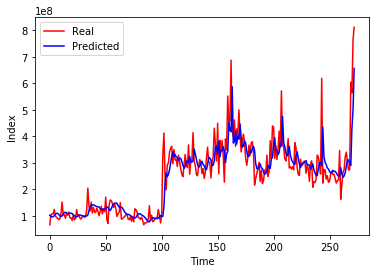

Epoch 1/50
772/772 [==============================] - 8s 10ms/step - loss: 0.0593
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0093
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0042
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0038
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0041
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0041
Epoch 13/50
772/772 [===

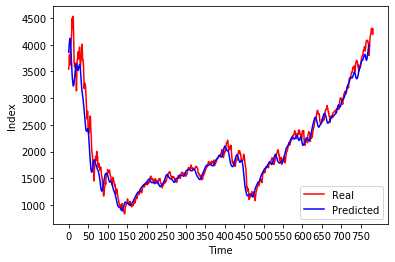

(273, 10, 1)


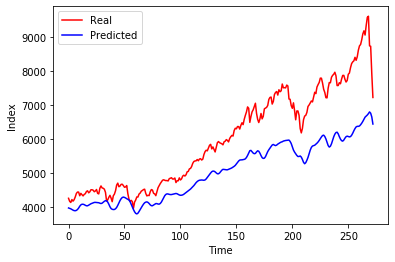

Epoch 1/50
772/772 [==============================] - 10s 13ms/step - loss: 0.0557
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0169A: 0s - loss: 0.0
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0171
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0166
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0152
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0157
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0158
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0158
Epoch 

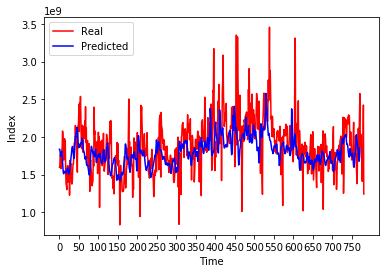

(273, 10, 1)


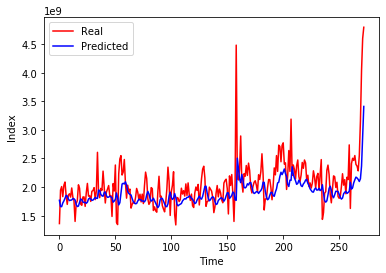

Epoch 1/50
772/772 [==============================] - 10s 13ms/step - loss: 0.1174
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0111
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0093
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0066A: 0s - lo
Epoch 13/50
7

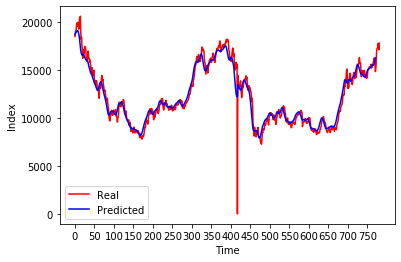

(273, 10, 1)


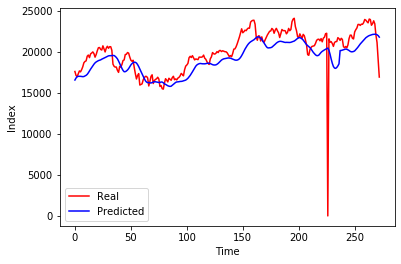

Epoch 1/50
772/772 [==============================] - 10s 13ms/step - loss: 0.0222
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0054
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0064
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 13/50
772/772 [==

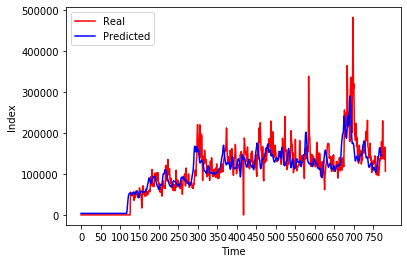

(273, 10, 1)


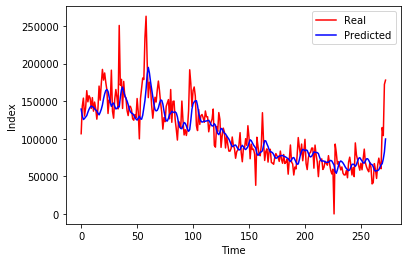

Epoch 1/50
772/772 [==============================] - 9s 12ms/step - loss: 0.2147
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0299
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0214
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0177
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0153
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0121
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0128A: 0s - l
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0132
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0122
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 13/50
772

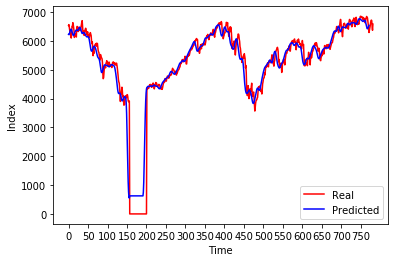

(273, 10, 1)


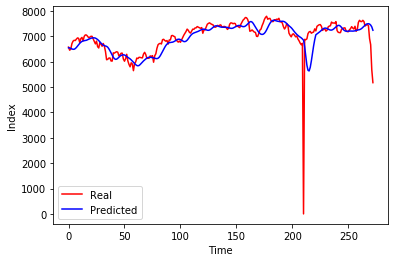

Epoch 1/50
772/772 [==============================] - 11s 14ms/step - loss: 0.0887
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0277
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0235
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0212
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0221
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0198
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0221
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0201
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0206
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0214
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0222
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0213
Epoch 13/50
772/772 [==

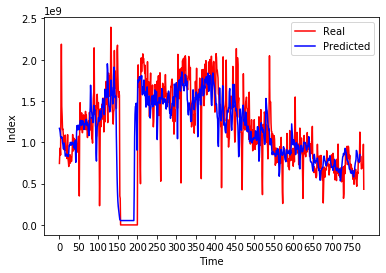

(273, 10, 1)


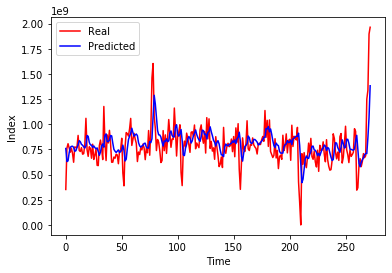

Epoch 1/50
772/772 [==============================] - 11s 15ms/step - loss: 0.0629
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0159
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0076
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0070A: 0s - loss: 0.007
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0062A: 0s - lo
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0062
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0

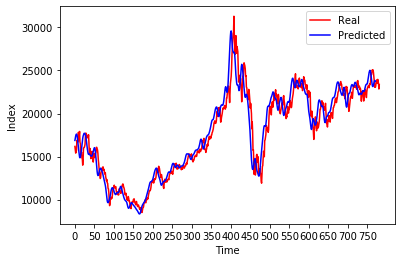

(273, 10, 1)


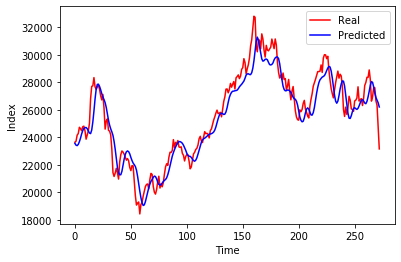

Epoch 1/50
772/772 [==============================] - 11s 14ms/step - loss: 0.0266 1s - loss: 0.02
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0090
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0086
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0078
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 1

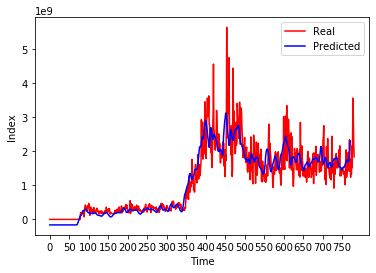

(273, 10, 1)


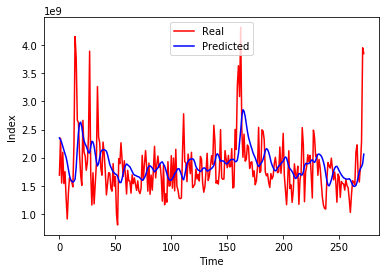

Epoch 1/50
772/772 [==============================] - 14s 18ms/step - loss: 0.0768 0s - loss: 0.079
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0134A: 0s - los
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0083
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0084
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0066
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0066A: 0s - loss: 0
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 12/50
772/772 [==============================] - 1s 1ms/

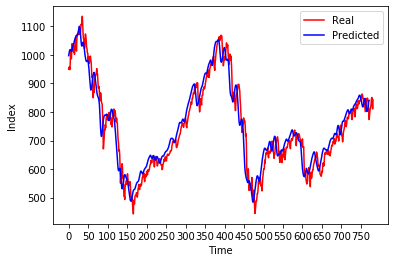

(273, 10, 1)


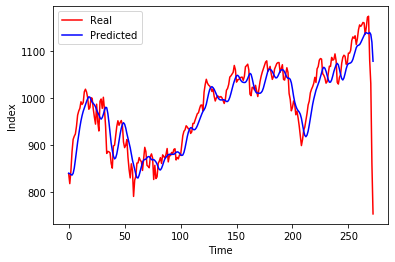

Epoch 1/50
772/772 [==============================] - 13s 17ms/step - loss: 0.0399
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0113
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0107A: 0s - l
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0102
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0101
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0093A: 0s - loss: 0.00
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0097
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0092
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0095A: 1s
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss

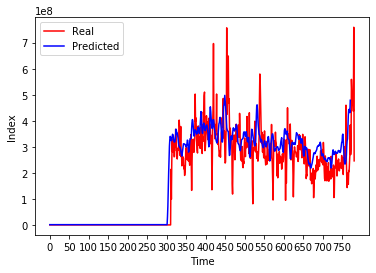

(273, 10, 1)


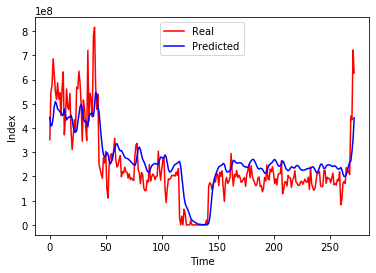

Epoch 1/50
772/772 [==============================] - 12s 15ms/step - loss: 0.0220
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0212
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0212
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0211
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0207
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0207
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0207
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0210
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0207
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0204
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0208A: 0s - los
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0211
Epoch 13/50


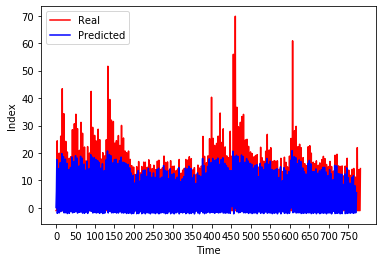

(273, 10, 1)


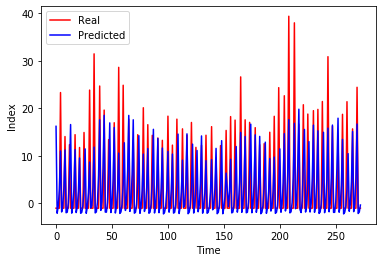

Epoch 1/50
772/772 [==============================] - 12s 16ms/step - loss: 0.0059
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0054
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0054
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 13/50
772/772 [==

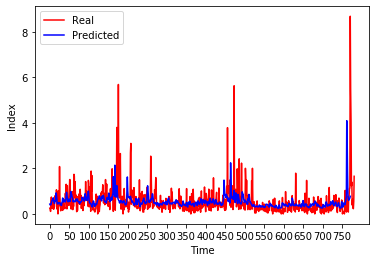

(273, 10, 1)


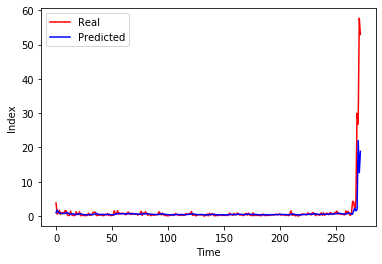

Epoch 1/50
772/772 [==============================] - 12s 15ms/step - loss: 0.0095
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0092
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0092
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0093
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0092
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0090
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0092
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0089
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0089
Epoch 13/50
772/772 [==

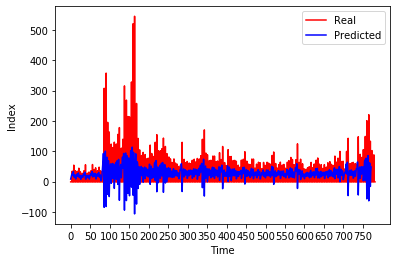

(273, 10, 1)


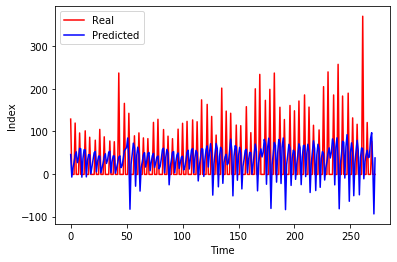

Epoch 1/50
772/772 [==============================] - 12s 15ms/step - loss: 0.0146
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0140
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 13/50
772/772 [==

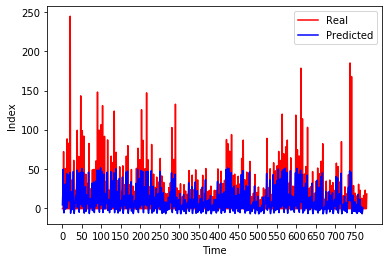

(273, 10, 1)


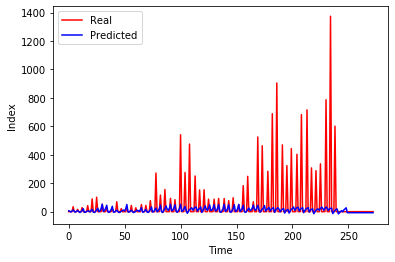

Epoch 1/50
772/772 [==============================] - 13s 16ms/step - loss: 0.0130
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0126
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0127
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 13/50
772/772 [==

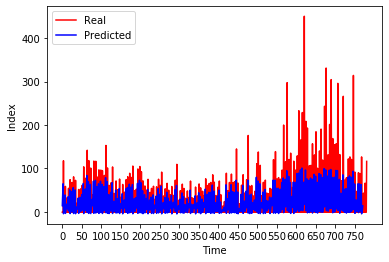

(273, 10, 1)


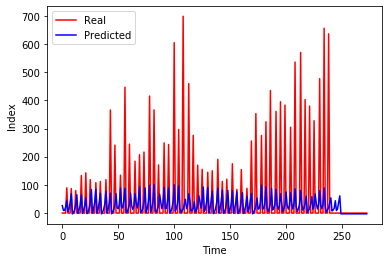

Epoch 1/50
772/772 [==============================] - 13s 17ms/step - loss: 0.1797
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1698
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1682
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1674
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1674A: 0s - loss: 0
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1679
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1669
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1662
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1641
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1689
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1689
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.1600
Epoch 13

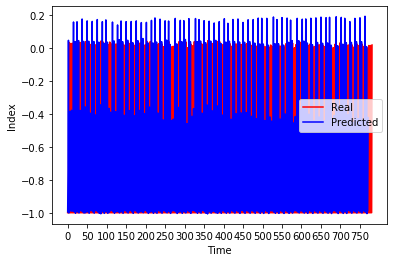

(273, 10, 1)


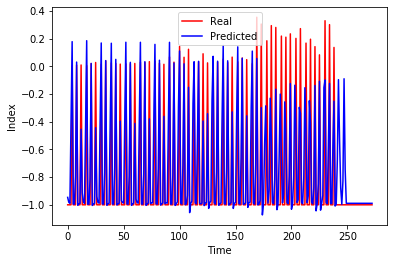

Epoch 1/50
772/772 [==============================] - 15s 20ms/step - loss: 0.0692
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0046A: 0s - loss: 0
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0039
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0041A: 1
Epoc

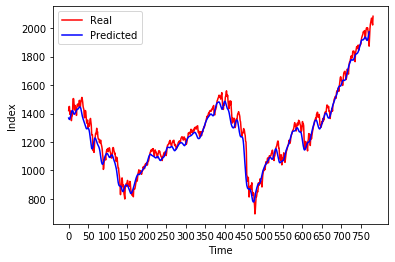

(273, 10, 1)


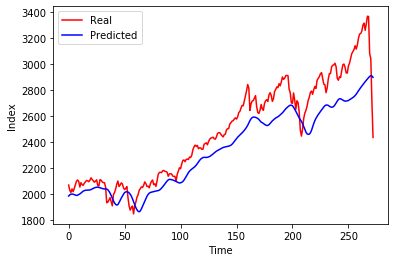

Epoch 1/50
772/772 [==============================] - 14s 19ms/step - loss: 0.0371
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0085
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0064
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 13/50
772/772 [==

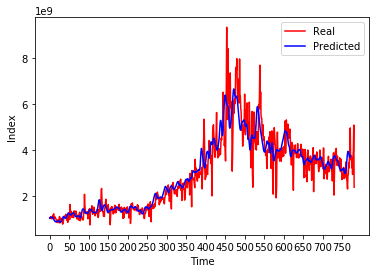

(273, 10, 1)


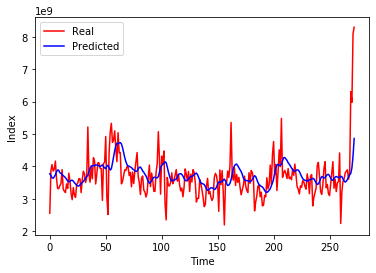

Epoch 1/50
772/772 [==============================] - 17s 23ms/step - loss: 0.0216
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0081
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0074
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0066
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0074
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 13/50
772/772 [==

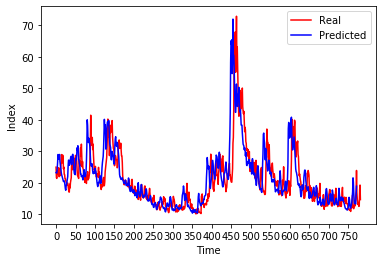

(273, 10, 1)


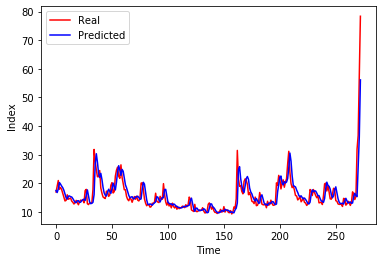

Epoch 1/50
772/772 [==============================] - 17s 23ms/step - loss: 0.0000e+00
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0000e+00
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0000e+00
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0000e+00
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0000e+00
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0000e+00A: 0s - los
Epoch 12/50
772/772 [=============================

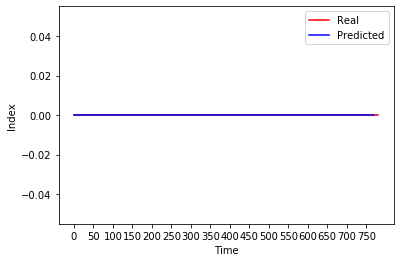

(273, 10, 1)


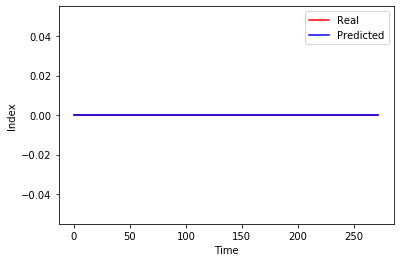

Epoch 1/50
772/772 [==============================] - 18s 24ms/step - loss: 0.0638
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0104
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0040
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0048
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0060A: 0s - loss: 0.008 - ET

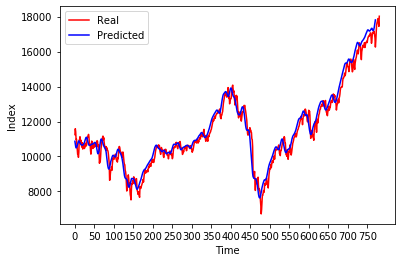

(273, 10, 1)


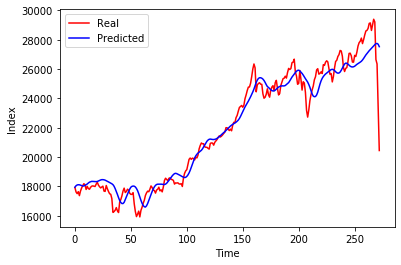

Epoch 1/50
772/772 [==============================] - 15s 19ms/step - loss: 0.0380 0s - loss: 0.03
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0168
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0126
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0114
Epoch 1

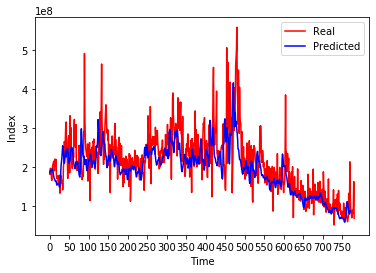

(273, 10, 1)


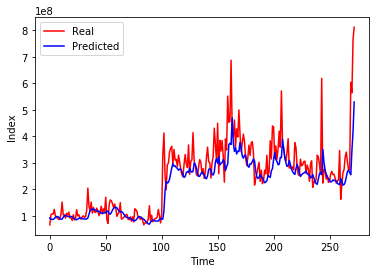

Epoch 1/50
772/772 [==============================] - 29s 38ms/step - loss: 0.0521
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0056A: 0
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0039A: 0s - los
Epoch 10/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0044
Epoch 11/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 13

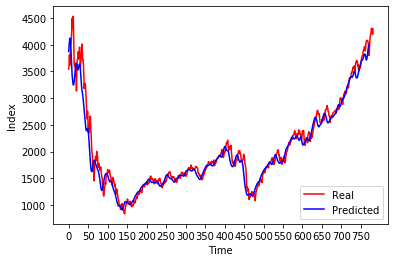

(273, 10, 1)


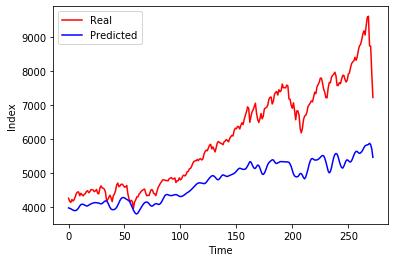

Epoch 1/50
772/772 [==============================] - 18s 24ms/step - loss: 0.0500 9s - loss
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0168
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0156A: 0s 
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0160A: 1s - los - ETA: 0s - loss:
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0162A: 0s - loss: 0
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0154A
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0150A: 0s - loss: 0
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0152
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0160
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0145
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0152
Epoch 12/50
772/772 [========

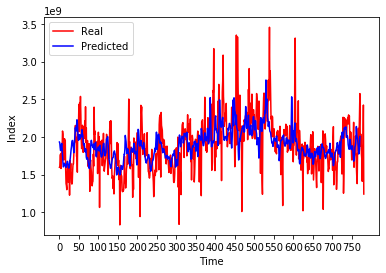

(273, 10, 1)


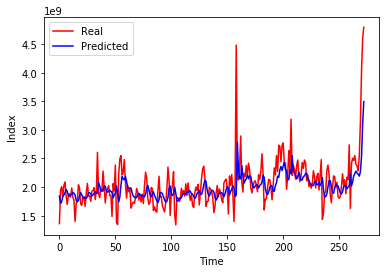

Epoch 1/50
772/772 [==============================] - 19s 25ms/step - loss: 0.0650
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0116
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0077
Epoch 4/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0076
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0065
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 9/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0066
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0059
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 13/50
772/772 [==

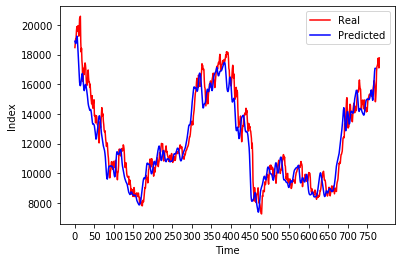

(273, 10, 1)


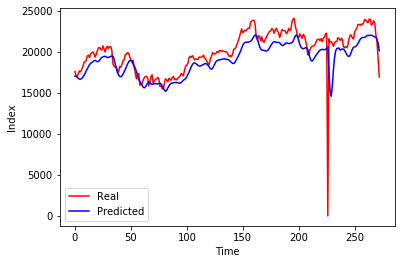

Epoch 1/50
772/772 [==============================] - 22s 28ms/step - loss: 0.0216
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0074
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0059
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0057
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 7/50
772/772 [==============================] - ETA: 0s - loss: 0.005 - 2s 2ms/step - loss: 0.0051
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0048
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0048
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0054

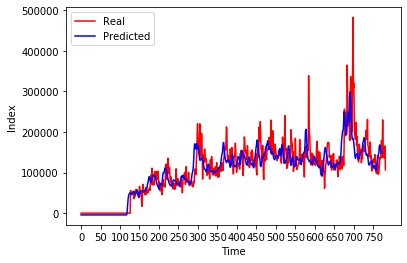

(273, 10, 1)


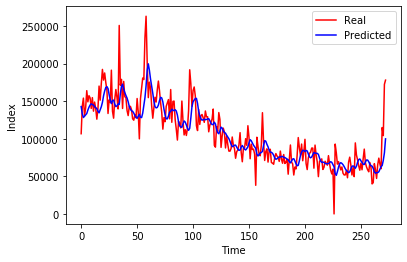

Epoch 1/50
772/772 [==============================] - 18s 24ms/step - loss: 0.1822
Epoch 2/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0237
Epoch 3/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0153A: 0s - loss
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 6/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 7/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0124
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0122A: 0s 
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0114
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0114
Epoch

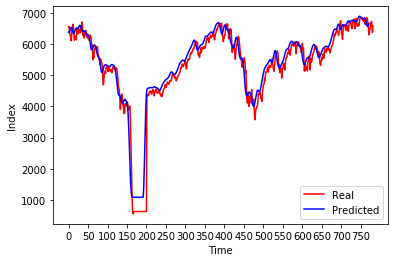

(273, 10, 1)


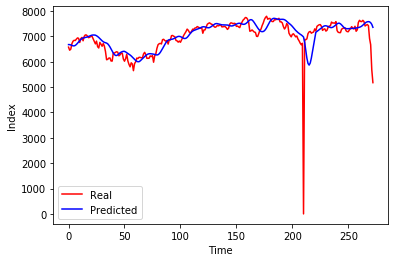

Epoch 1/50
772/772 [==============================] - 20s 27ms/step - loss: 0.0739
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0272
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0214
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0205
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0197
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0212
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0208
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0201
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0201
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0205
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0198
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0197
Epoch 13/50
772/772 [==

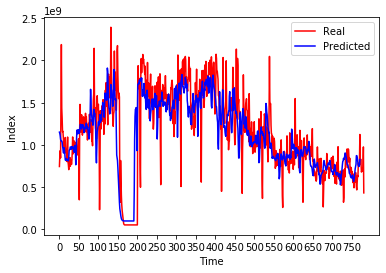

(273, 10, 1)


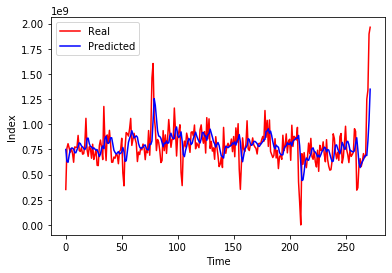

Epoch 1/50
772/772 [==============================] - 26s 33ms/step - loss: 0.0619
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0127
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 4/50
772/772 [==============================] - 3s 3ms/step - loss: 0.0063
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0066
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0061
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0057
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0060
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0057
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0052A: 0s - loss:
Epoch 13/5

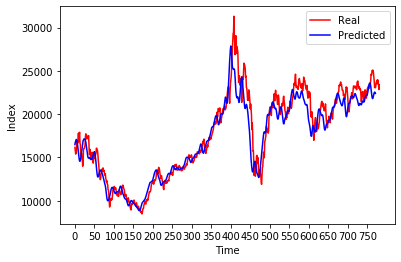

(273, 10, 1)


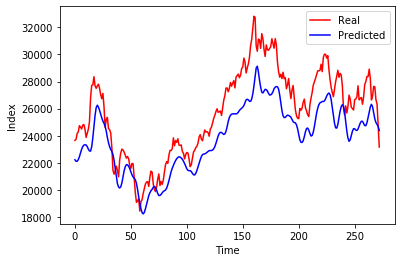

Epoch 1/50
772/772 [==============================] - 20s 26ms/step - loss: 0.0268
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0087
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0076
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0072
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0064
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0064
Epoch 11/50
772/772 [==============================] - ETA: 0s - loss: 0.006 - 2s 2ms/step - loss: 0.0064
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0063

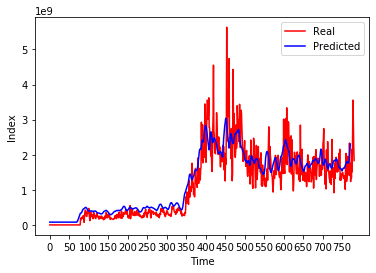

(273, 10, 1)


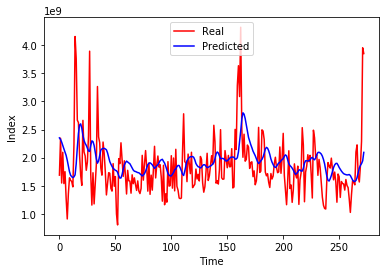

Epoch 1/50
772/772 [==============================] - 24s 31ms/step - loss: 0.0646
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0119A: 0s - loss: - ETA: 0s - loss: 0.012
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0080
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0071
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0070
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0065
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0073
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0069
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0065
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0068
Epoch 12/50
772/772 [==============================] - 2s 2ms/step -

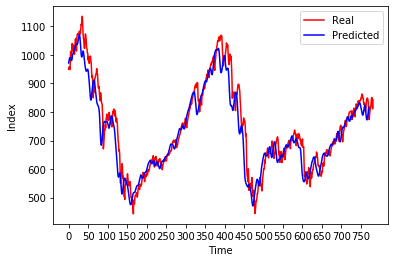

(273, 10, 1)


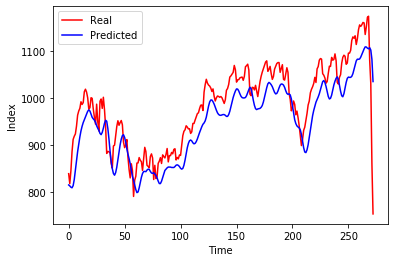

Epoch 1/50
772/772 [==============================] - 20s 26ms/step - loss: 0.0370
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0110
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0103
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0110
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0097
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0096
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0098
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0093
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0084
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0092
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0085
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0096
Epoch 13/50
772/772 [==

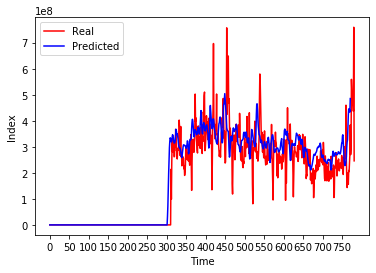

(273, 10, 1)


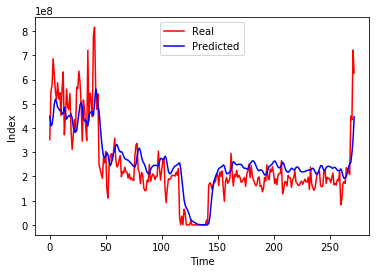

Epoch 1/50
772/772 [==============================] - 21s 27ms/step - loss: 0.0223
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0202
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0198
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0199
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0201
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0195
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0192
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0204A: 0s - loss: 0.02
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0196
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0192
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0194
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0190
Epoch

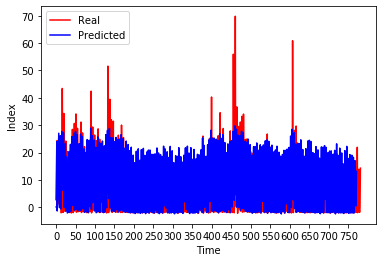

(273, 10, 1)


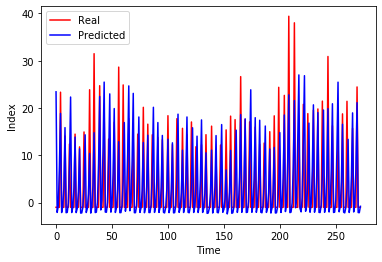

Epoch 1/50
772/772 [==============================] - 21s 27ms/step - loss: 0.0057
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 13/50
772/772 [==

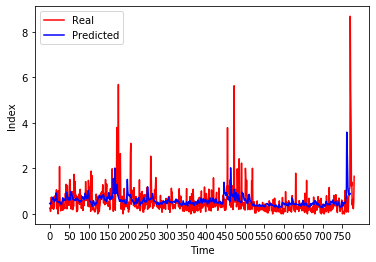

(273, 10, 1)


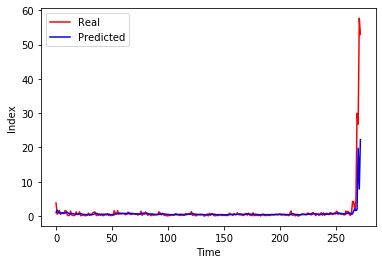

Epoch 1/50
772/772 [==============================] - 47s 61ms/step - loss: 0.0164
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0060
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0059
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0061
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0061
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0060
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 13/50
772/772 [==

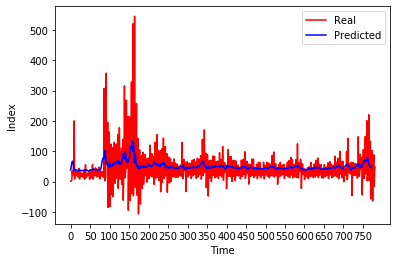

(273, 10, 1)


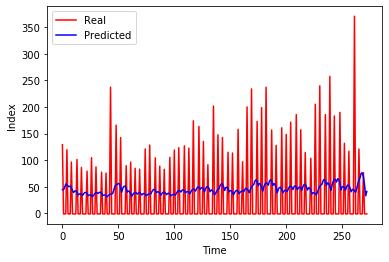

Epoch 1/50
772/772 [==============================] - 23s 30ms/step - loss: 0.0022
Epoch 2/50
772/772 [==============================] - 2s 2ms/step - loss: 4.2797e-04
Epoch 3/50
772/772 [==============================] - 2s 2ms/step - loss: 3.7726e-04
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 3.4906e-04
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 3.6629e-04
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 3.4709e-04
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 3.5425e-04
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 3.2945e-04
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 3.5363e-04
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 3.2783e-04
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 3.6251e-04
Epoch 12/50
772/772 [==============================] - 2s 2ms/ste

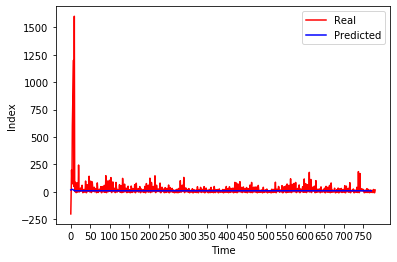

(273, 10, 1)


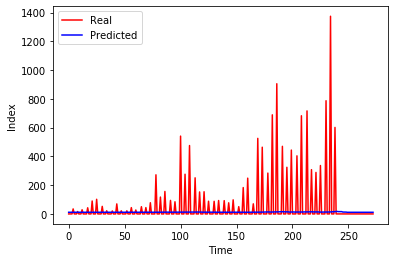

Epoch 1/50
772/772 [==============================] - 23s 29ms/step - loss: 0.0067
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0031
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0031A: 1
Epoch 4/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 5/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 6/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 7/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0030
Epoch 8/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 9/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0030
Epoch 10/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 11/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 12/50
772/772 [==============================] - 2s 2ms/step - loss: 0.0030
Epoch 13/50
772/772

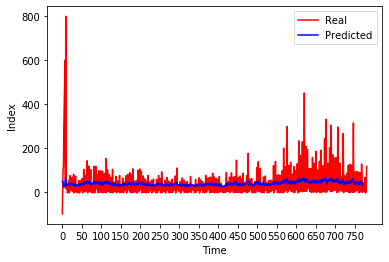

(273, 10, 1)


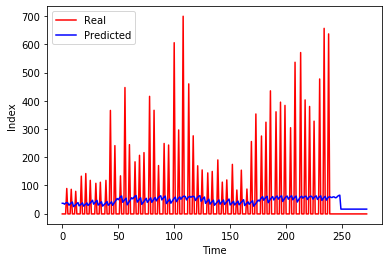

Epoch 1/50
772/772 [==============================] - 24s 31ms/step - loss: 0.0695
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0554
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0554
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0555
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0560
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0555
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0562
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0550
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0561
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0543
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0551
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0553
Epoch 13/50
772/772 [==

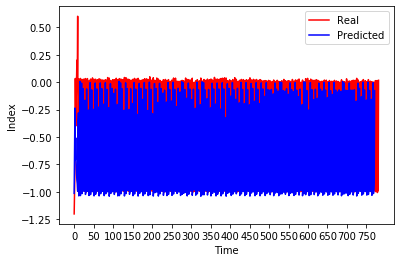

(273, 10, 1)


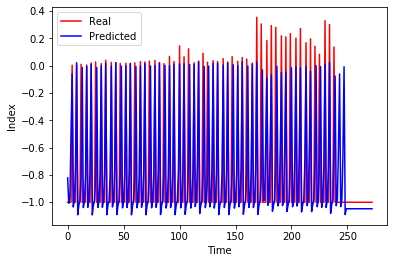

Epoch 1/50
772/772 [==============================] - 24s 31ms/step - loss: 0.0566
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0114A: 0s - loss: 0.
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0051A: 0s - loss: 0
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0042
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - loss:

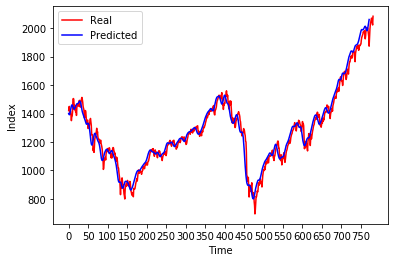

(273, 10, 1)


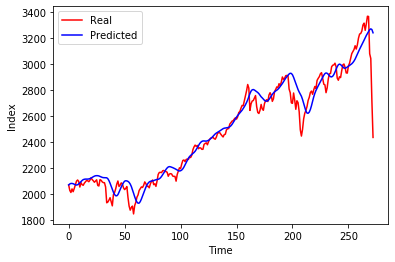

Epoch 1/50
772/772 [==============================] - 25s 32ms/step - loss: 0.0344
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0086
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0072
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0070
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0069
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0071
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0068
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0066A: 0s - los
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0068
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0065
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0068A: 1
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0065A: 0s - l

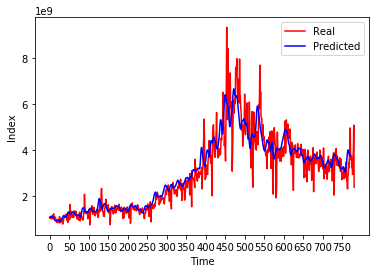

(273, 10, 1)


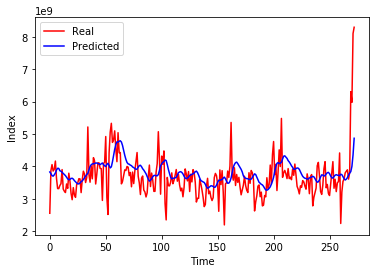

Epoch 1/50
772/772 [==============================] - 26s 33ms/step - loss: 0.0212
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0086
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0090
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0083
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0078
Epoch 6/50
772/772 [==============================] - 3s 3ms/step - loss: 0.0083A: 0s - loss: 0.0
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0074
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0067
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0078
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0075A: 0s - loss: 0.00
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0060
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - l

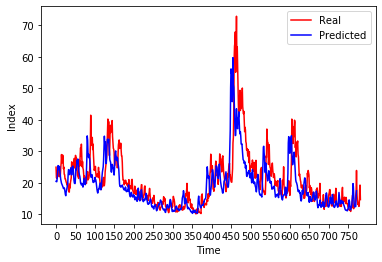

(273, 10, 1)


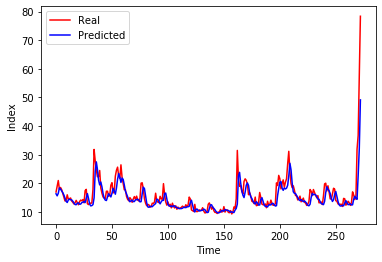

Epoch 1/50
772/772 [==============================] - 85s 110ms/step - loss: 0.0000e+00: 1
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00A
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00A
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00A: 1s - los
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00A: 0s - loss: 0.0000e
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0000e+00
Epoch 12/50
772/772 [==

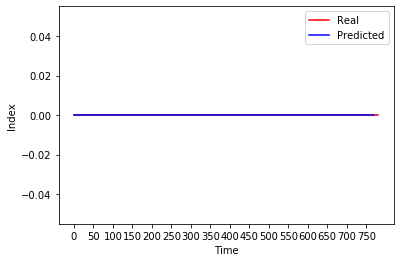

(273, 10, 1)


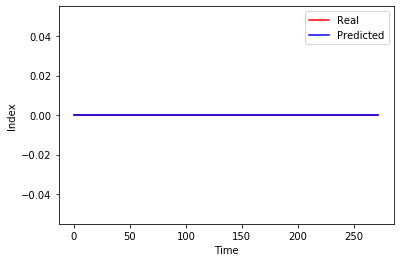

Epoch 1/50
772/772 [==============================] - 28s 36ms/step - loss: 0.0633
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0101
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0044A: 1
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0045A: 0s - loss:
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0045A: 0s - l
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0043
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0043A: 0s - loss: 0.00
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 12/50
772/772 [==============================] - 2s 3ms

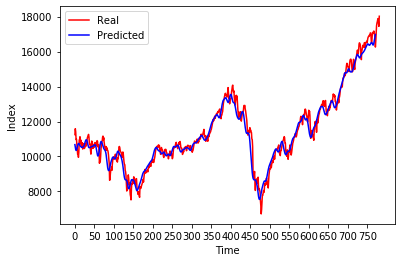

(273, 10, 1)


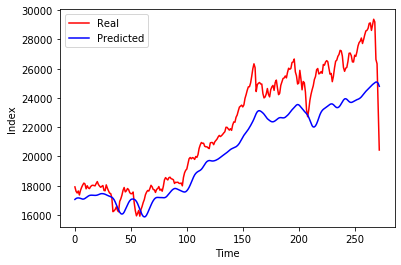

Epoch 1/50
772/772 [==============================] - 28s 36ms/step - loss: 0.0410 5s - loss: 0
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0171
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0141
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0130
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0120A
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0128
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0118
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0130
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0120A: 
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0119
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0114A: 0s - loss: 0.0 - ETA: 0s - loss: 
Epoch 12/50
772/772 [==============================]

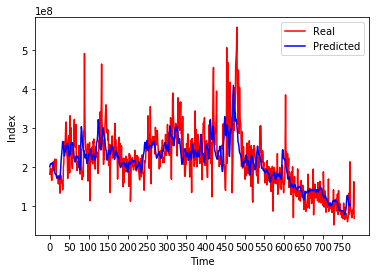

(273, 10, 1)


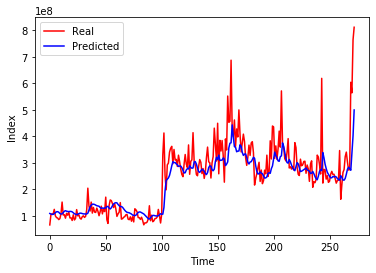

Epoch 1/50
772/772 [==============================] - 29s 37ms/step - loss: 0.0614 16s -
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0100
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0057
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0051A: 0s - los
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0052
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0058A: 0s - loss: 0.0
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0050A: 1s -  - ETA: 0s - loss:
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0042A: 0s - loss: 0.0
Epoch 12/50
772/772 [=======

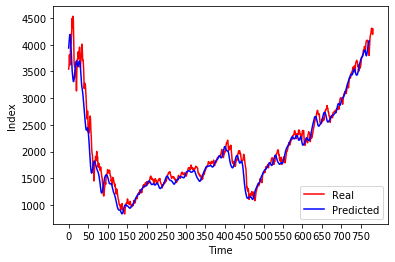

(273, 10, 1)


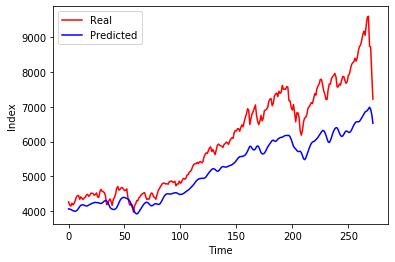

Epoch 1/50
772/772 [==============================] - 30s 39ms/step - loss: 0.0550 24s - - ETA: 4s - loss: 0.
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0162
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0169
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0159
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0154A: 1s - los - ETA: 0s - l
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0154A: 1s - loss: 0.01 - ET
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0166
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0162A: 1s - loss: 0.02 - E
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0153A: 1s - los - ETA: 0s - l
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0151
Epoch 11/50
772/772 [==============================] - 2s 3ms/ste

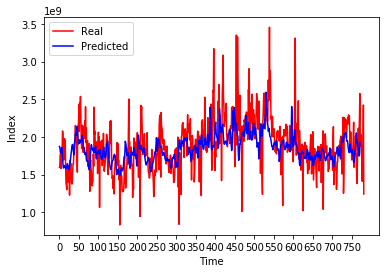

(273, 10, 1)


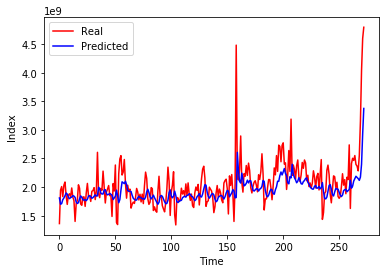

Epoch 1/50
772/772 [==============================] - 32s 42ms/step - loss: 0.0610 3s - loss: 0.0
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0101A: 
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0075
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0072
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0081A: 0s - loss: 0.
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0067
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0064A: 1s -  - ETA: 0s - l
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0066A: 1s
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0060
Epoch 12/50
772/772 [=======================

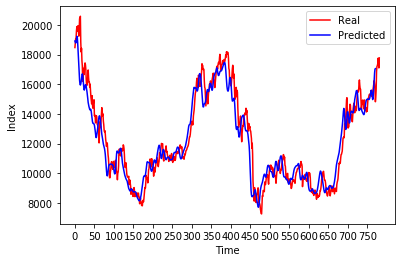

(273, 10, 1)


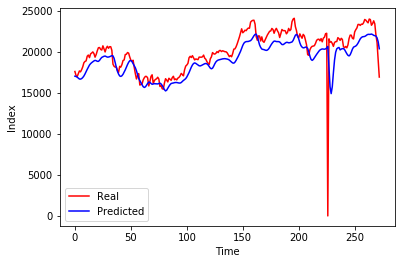

Epoch 1/50
772/772 [==============================] - 31s 40ms/step - loss: 0.0226
Epoch 2/50
772/772 [==============================] - ETA: 0s - loss: 0.007 - 2s 3ms/step - loss: 0.0070
Epoch 3/50
772/772 [==============================] - 3s 3ms/step - loss: 0.0063
Epoch 4/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0054
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0053A: 0s - lo
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0054
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0051
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0061
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0054
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0050
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - lo

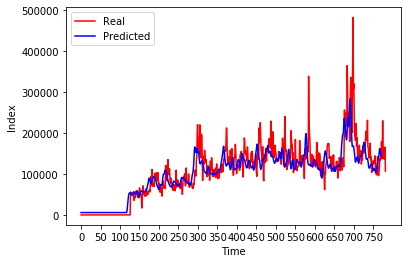

(273, 10, 1)


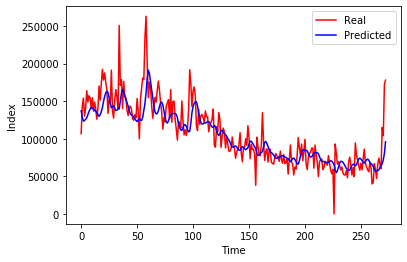

Epoch 1/50
772/772 [==============================] - 33s 43ms/step - loss: 0.1408
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0217
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0169
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0147
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0135
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0131
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0123
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0129
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0124
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0121
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0107A: 
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0115
Epoch 13/50
772/772 

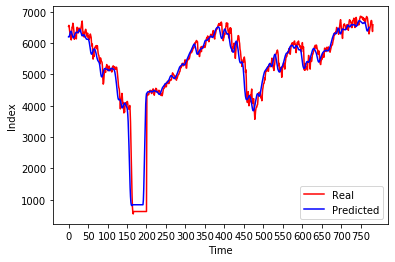

(273, 10, 1)


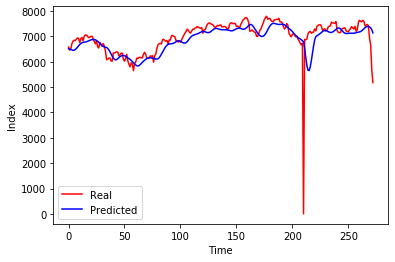

Epoch 1/50
772/772 [==============================] - 34s 45ms/step - loss: 0.0790
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0259
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0220A: 0s - loss: 0.
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0257
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0217A: 0s - loss: 0.021
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0208
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0210
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0209
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0211A: 1s - lo - ETA: 0s - loss: 0
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0217
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0200A: 1s - 
Epoch 12/50
772/772 [===========

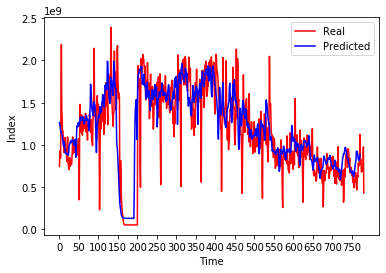

(273, 10, 1)


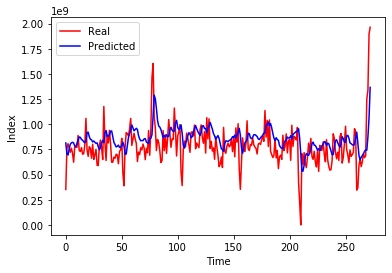

Epoch 1/50
772/772 [==============================] - 95s 123ms/step - loss: 0.0694
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0123
Epoch 3/50
772/772 [==============================] - ETA: 0s - loss: 0.007 - 2s 3ms/step - loss: 0.0071
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0069A: 0s - l
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0070
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0059
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0056
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0055
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - lo

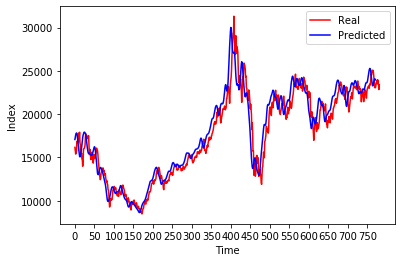

(273, 10, 1)


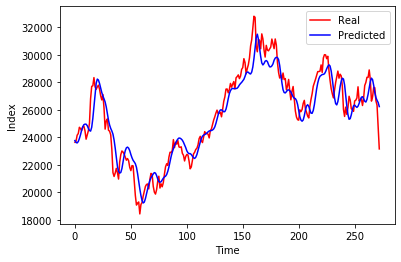

Epoch 1/50
772/772 [==============================] - 35s 46ms/step - loss: 0.0240
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0080
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0071
Epoch 4/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0071
Epoch 5/50
772/772 [==============================] - 3s 3ms/step - loss: 0.0066
Epoch 6/50
772/772 [==============================] - ETA: 0s - loss: 0.006 - 3s 3ms/step - loss: 0.0065
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0065
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0064
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0067
Epoch 10/50
772/772 [==============================] - 3s 3ms/step - loss: 0.0065
Epoch 11/50
772/772 [==============================] - 3s 3ms/step - loss: 0.0064
Epoch 12/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063

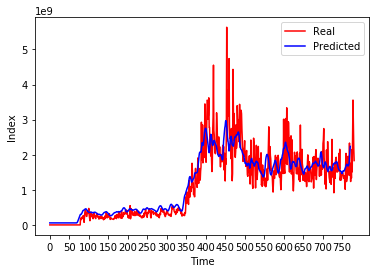

(273, 10, 1)


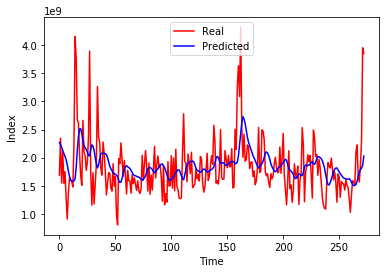

Epoch 1/50
772/772 [==============================] - ETA: 0s - loss: 0.075 - 36s 46ms/step - loss: 0.0746
Epoch 2/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0118
Epoch 3/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0086
Epoch 4/50
772/772 [==============================] - ETA: 0s - loss: 0.007 - 2s 3ms/step - loss: 0.0076
Epoch 5/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0068
Epoch 6/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0064
Epoch 7/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 8/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0071
Epoch 9/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0065
Epoch 10/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0064
Epoch 11/50
772/772 [==============================] - 2s 3ms/step - loss: 0.0062
Epoch 12/50
772/772 [==============================] - ET

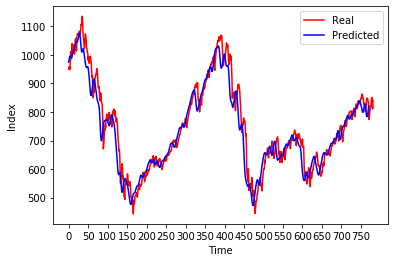

(273, 10, 1)


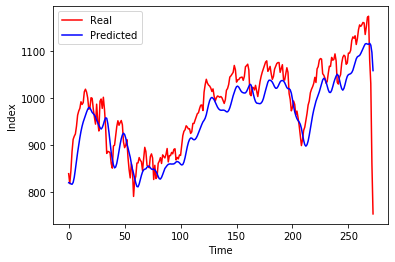

Epoch 1/50
772/772 [==============================] - 50s 64ms/step - loss: 0.0379
Epoch 2/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0119
Epoch 3/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0102
Epoch 4/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0103
Epoch 5/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0095
Epoch 6/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0093
Epoch 7/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0094
Epoch 8/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0093
Epoch 9/50
772/772 [==============================] - 3s 3ms/step - loss: 0.0090
Epoch 10/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0088
Epoch 11/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0094
Epoch 12/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0091
Epoch 13/50
772/772 [==

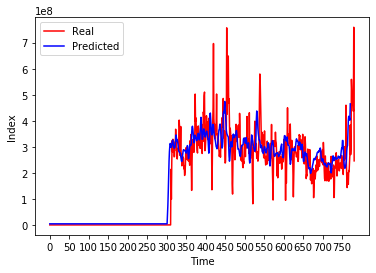

(273, 10, 1)


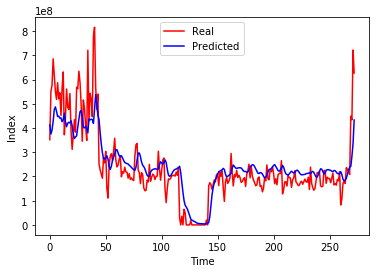

Epoch 1/50
772/772 [==============================] - 45s 58ms/step - loss: 0.0222
Epoch 2/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0199
Epoch 3/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0202
Epoch 4/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0199
Epoch 5/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0200
Epoch 6/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0196
Epoch 7/50
772/772 [==============================] - 3s 5ms/step - loss: 0.0193
Epoch 8/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0192
Epoch 9/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0194
Epoch 10/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0194
Epoch 11/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0188
Epoch 12/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0197
Epoch 13/50
772/772 [==

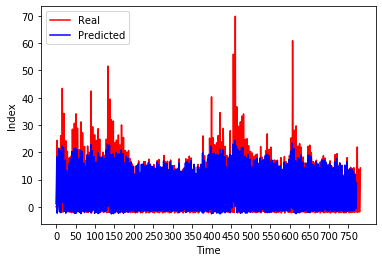

(273, 10, 1)


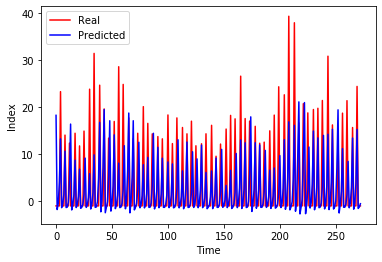

Epoch 1/50
772/772 [==============================] - 61s 79ms/step - loss: 0.0059
Epoch 2/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0054
Epoch 3/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0053
Epoch 4/50
772/772 [==============================] - 4s 5ms/step - loss: 0.0053
Epoch 5/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0053
Epoch 6/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0052
Epoch 7/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0052
Epoch 8/50
288/772 [==========>...................] - ETA: 1s - loss: 0.0082

In [ ]:
for i in range(0,30):
    df_train_complete = None
    df_test_complete = None
    for col in df.columns:
        test_set = df.loc['2015-01-02':, col].fillna(-1).values #Selecting test data
        training_set = df.loc['2000-01-01':'2015-01-01', col].fillna(-1).values #Selecting training data
        training_set = training_set.reshape(-1, 1)
        X_train, y_train, sc = scale(training_set)
        model = train_LSTM(X_train, y_train)
        # Dados de treinamento
        predicted_stock_price_train = model.predict(X_train)
        predicted_stock_price_train = sc.inverse_transform(predicted_stock_price_train)
        plot_results(df.loc['2000-01-01':'2015-01-01', col].fillna(-1), predicted_stock_price_train)
        # Dados de teste
        X_test, predicted_stock_price = predict(df.loc['2000-01-01':'2015-01-01', col].fillna(-1), df.loc['2015-01-02':, col].fillna(-1), model, sc)
        plot_results(df.loc['2015-01-02':, col].fillna(-1), predicted_stock_price)

        vazio = np.empty(days)
        predicted_stock_price_train = np.append(vazio, predicted_stock_price_train)
        series_complete_train = impute_with_prediction(df.loc['2000-01-01':'2015-01-01', col], pd.DataFrame(index=df.loc['2000-01-01':'2015-01-01', col].index, data=predicted_stock_price_train))
        df_train_complete = pd.concat([df_train_complete, pd.DataFrame(index=df.loc['2000-01-01':'2015-01-01', col].index, data=series_complete_train, columns=[col])], axis=1, join='outer')
        df_test_complete = pd.concat([df_test_complete, pd.DataFrame(data=predicted_stock_price, index = df.loc['2015-01-02':, col].index, columns = [col])], axis=1, join='outer')
        df_train_complete.to_csv(r'output\/CompleteIndexesWeeklyTrainLSTM10_'+str(i)+'.csv', index = True)
        df_test_complete.to_csv(r'output\/CompleteIndexesWeeklyTestLSTM10_'+str(i)+'.csv', index = True)